# GroundingDINO with Segment Anything - Image Editing Demo

This notebook demonstrates how to use GroundingDINO for object detection combined with Segment Anything for segmentation, and then use Hugging Face's diffusers library for local AI-powered image editing.

## Overview

The workflow consists of the following steps:
1. **Object Detection**: Use GroundingDINO to detect objects based on text prompts
2. **Segmentation**: Use Segment Anything to create precise masks for detected objects
3. **Mask Preparation**: Combine and process masks for image editing
4. **Image Editing**: Use Hugging Face's diffusers with DreamShaper-8 model for local inpainting
5. **Visualization**: Display original and edited images side by side

## Features
- Text-based object detection with GroundingDINO
- High-quality segmentation with SAM (Segment Anything Model)
- **Completely local** AI-powered image editing with Hugging Face diffusers (no API keys required)
- GPU acceleration for fast processing
- Interactive visualizations with Plotly and Matplotlib
- Reproducible results with seed control
- New end-to-end function for simplified workflows

## Setup and Imports

Import all required libraries and initialize the environment.

In [1]:
# Standard library imports
import io
import os
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from dotenv import load_dotenv
import cv2

# New refactored services
from writing_tool.services import (
    WritingToolService,
    ObjectDetectionService,
    SegmentationService,
    PromptNormalizationService,
    InpaintingService,
    VisualizationService,
    ImageService,
)

# Entity imports
from writing_tool.entities import BoundingBox, DetectionResult

/home/niits/code/experiments/demos/writing_tool/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables (no longer needed for OpenAI)
load_dotenv()

# Initialize the main writing tool service with Hugging Face inpainting
writing_tool = WritingToolService(
    detector_model_id="IDEA-Research/grounding-dino-tiny",
    segmenter_model_id="facebook/sam-vit-base",
    inpainting_model_id="diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    device="cuda",  # Use "cpu" if no GPU available
)

# Access logger for status updates
from writing_tool.logging_config import get_logger
logger = get_logger(__name__)

logger.info("Writing Tool Service initialized successfully!")
logger.info(f"   - Object Detection Service: {writing_tool.detection_service.model_id}")
logger.info(f"   - Segmentation Service: {writing_tool.segmentation_service.model_id}")
logger.info(f"   - Inpainting Service: {writing_tool.inpainting_service.pipe.config._name_or_path}")
logger.info(f"   - Device: {writing_tool.detection_service.device}")
logger.info(f"   - Inpainting Device: {writing_tool.inpainting_service.device}")

2025-08-02 16:15:45,857 - writing_tool.services.segmentation_service - INFO - Loading SAM model: facebook/sam-vit-base
2025-08-02 16:15:46,440 - writing_tool.services.segmentation_service - INFO - SAM model loaded successfully on cuda
2025-08-02 16:15:46,440 - writing_tool.services.segmentation_service - INFO - SAM model loaded successfully on cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 15.97it/s]



2025-08-02 16:16:52,976 - writing_tool.services.writing_tool_service - INFO - WritingToolService initialized with device: cuda
2025-08-02 16:16:52,977 - __main__ - INFO - Writing Tool Service initialized successfully!
2025-08-02 16:16:52,977 - __main__ - INFO -    - Object Detection Service: IDEA-Research/grounding-dino-tiny
2025-08-02 16:16:52,978 - __main__ - INFO -    - Segmentation Service: facebook/sam-vit-base
2025-08-02 16:16:52,978 - __main__ - INFO -    - Inpainting Service: diffusers/stable-diffusion-xl-1.0-inpainting-0.1
2025-08-02 16:16:52,978 - __main__ - INFO -    - Device: cuda
2025-08-02 16:16:52,979 - __main__ - INFO -    - Inpainting Device: cuda
2025-08-02 16:16:52,977 - __main__ - INFO - Writing Tool Service initialized successfully!
2025-08-02 16:16:52,977 - __main__ - INFO -    - Object Detection Service: IDEA-Research/grounding-dino-tiny
2025-08-02 16:16:52,978 - __main__ - INFO -    - Segmentation Service: facebook/sam-vit-base
2025-08-02 16:16:52,978 - __main__

## Configuration

Configure the detection parameters, image source, and model IDs.

In [3]:
# Image source and detection parameters
image_url = "./image.png"
labels = [
    "boy",
    "swimming goggles",
    "swimming cap",
    "orange buoy",
]
threshold = 0.3  # Detection confidence threshold

# Model configurations
detector_id = "IDEA-Research/grounding-dino-tiny"  # GroundingDINO model
segmenter_id = "facebook/sam-vit-base"  # Segment Anything model

## Object Detection and Segmentation

Use GroundingDINO to detect objects and Segment Anything to create precise masks.

In [4]:
# Option 1: Use the integrated service for detection and segmentation
image_array, detections = writing_tool.detect_and_segment(
    image_source=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=False,  # Disabled to avoid OpenCV issues
    visualize=False,  # We'll visualize separately
)

logger.info(f"Detection and segmentation complete!")
logger.info(f"   - Image shape: {image_array.shape}")
logger.info(f"   - Objects detected: {len(detections)}")

# Option 2: Alternative using individual services (commented out)
# image = writing_tool.image_service.load_image(image_url)
# image_array = writing_tool.image_service.to_numpy(image)
# detections = writing_tool.detection_service.detect(image, labels, threshold)
# detections = writing_tool.segmentation_service.segment(image, detections, False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda
Device set to use cuda
/home/niits/code/experiments/demos/writing_tool/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/home/niits/code/experiments/demos/writing_tool/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


2025-08-02 16:17:00,733 - __main__ - INFO - Detection and segmentation complete!
2025-08-02 16:17:00,734 - __main__ - INFO -    - Image shape: (1238, 2026, 3)
2025-08-02 16:17:00,734 - __main__ - INFO -    - Objects detected: 4
2025-08-02 16:17:00,734 - __main__ - INFO -    - Image shape: (1238, 2026, 3)
2025-08-02 16:17:00,734 - __main__ - INFO -    - Objects detected: 4


In [5]:
# Visualize detection results with the new visualization service
writing_tool.visualization_service.plot_detections_plotly(image_array, detections)

# Alternative: Use matplotlib visualization
# writing_tool.visualization_service.plot_detections_matplotlib(
#     image_array, detections, show_masks=True, show_boxes=True
# )

## Mask Processing

Combine individual object masks and prepare them for image editing.

In [6]:
# Use the segmentation service to combine masks
combined_mask = writing_tool.segmentation_service.combine_masks(detections)

logger.info(f"Combined mask created!")
if combined_mask.size > 0:
    logger.info(f"   - Mask shape: {combined_mask.shape}")
    logger.info(f"   - Mask type: {combined_mask.dtype}")
    logger.info(f"   - Total masked pixels: {np.sum(combined_mask)}")
else:
    logger.info("   - No masks to combine")

2025-08-02 16:17:01,125 - __main__ - INFO - Combined mask created!
2025-08-02 16:17:01,126 - __main__ - INFO -    - Mask shape: (1238, 2026)
2025-08-02 16:17:01,126 - __main__ - INFO -    - Mask type: bool
2025-08-02 16:17:01,127 - __main__ - INFO -    - Total masked pixels: 280530
2025-08-02 16:17:01,126 - __main__ - INFO -    - Mask shape: (1238, 2026)
2025-08-02 16:17:01,126 - __main__ - INFO -    - Mask type: bool
2025-08-02 16:17:01,127 - __main__ - INFO -    - Total masked pixels: 280530


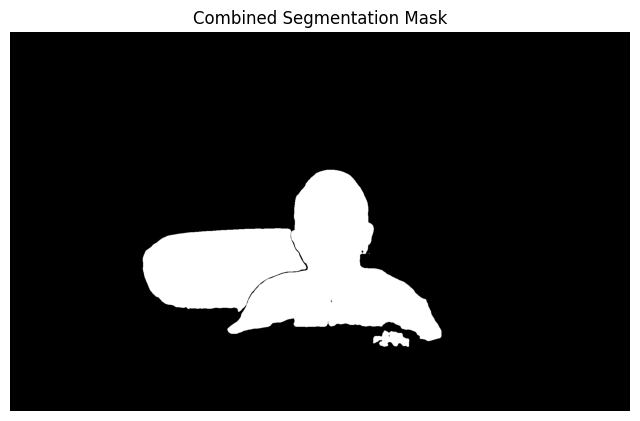

In [7]:
# Visualize the combined mask using the visualization service
if combined_mask.size > 0:
    writing_tool.visualization_service.display_mask(
        combined_mask, title="Combined Segmentation Mask"
    )
else:
    logger.info("No mask to display")

2025-08-02 16:17:01,520 - __main__ - INFO - Image info: {'size': (2026, 1238), 'mode': 'RGB', 'format': None, 'width': 2026, 'height': 1238}


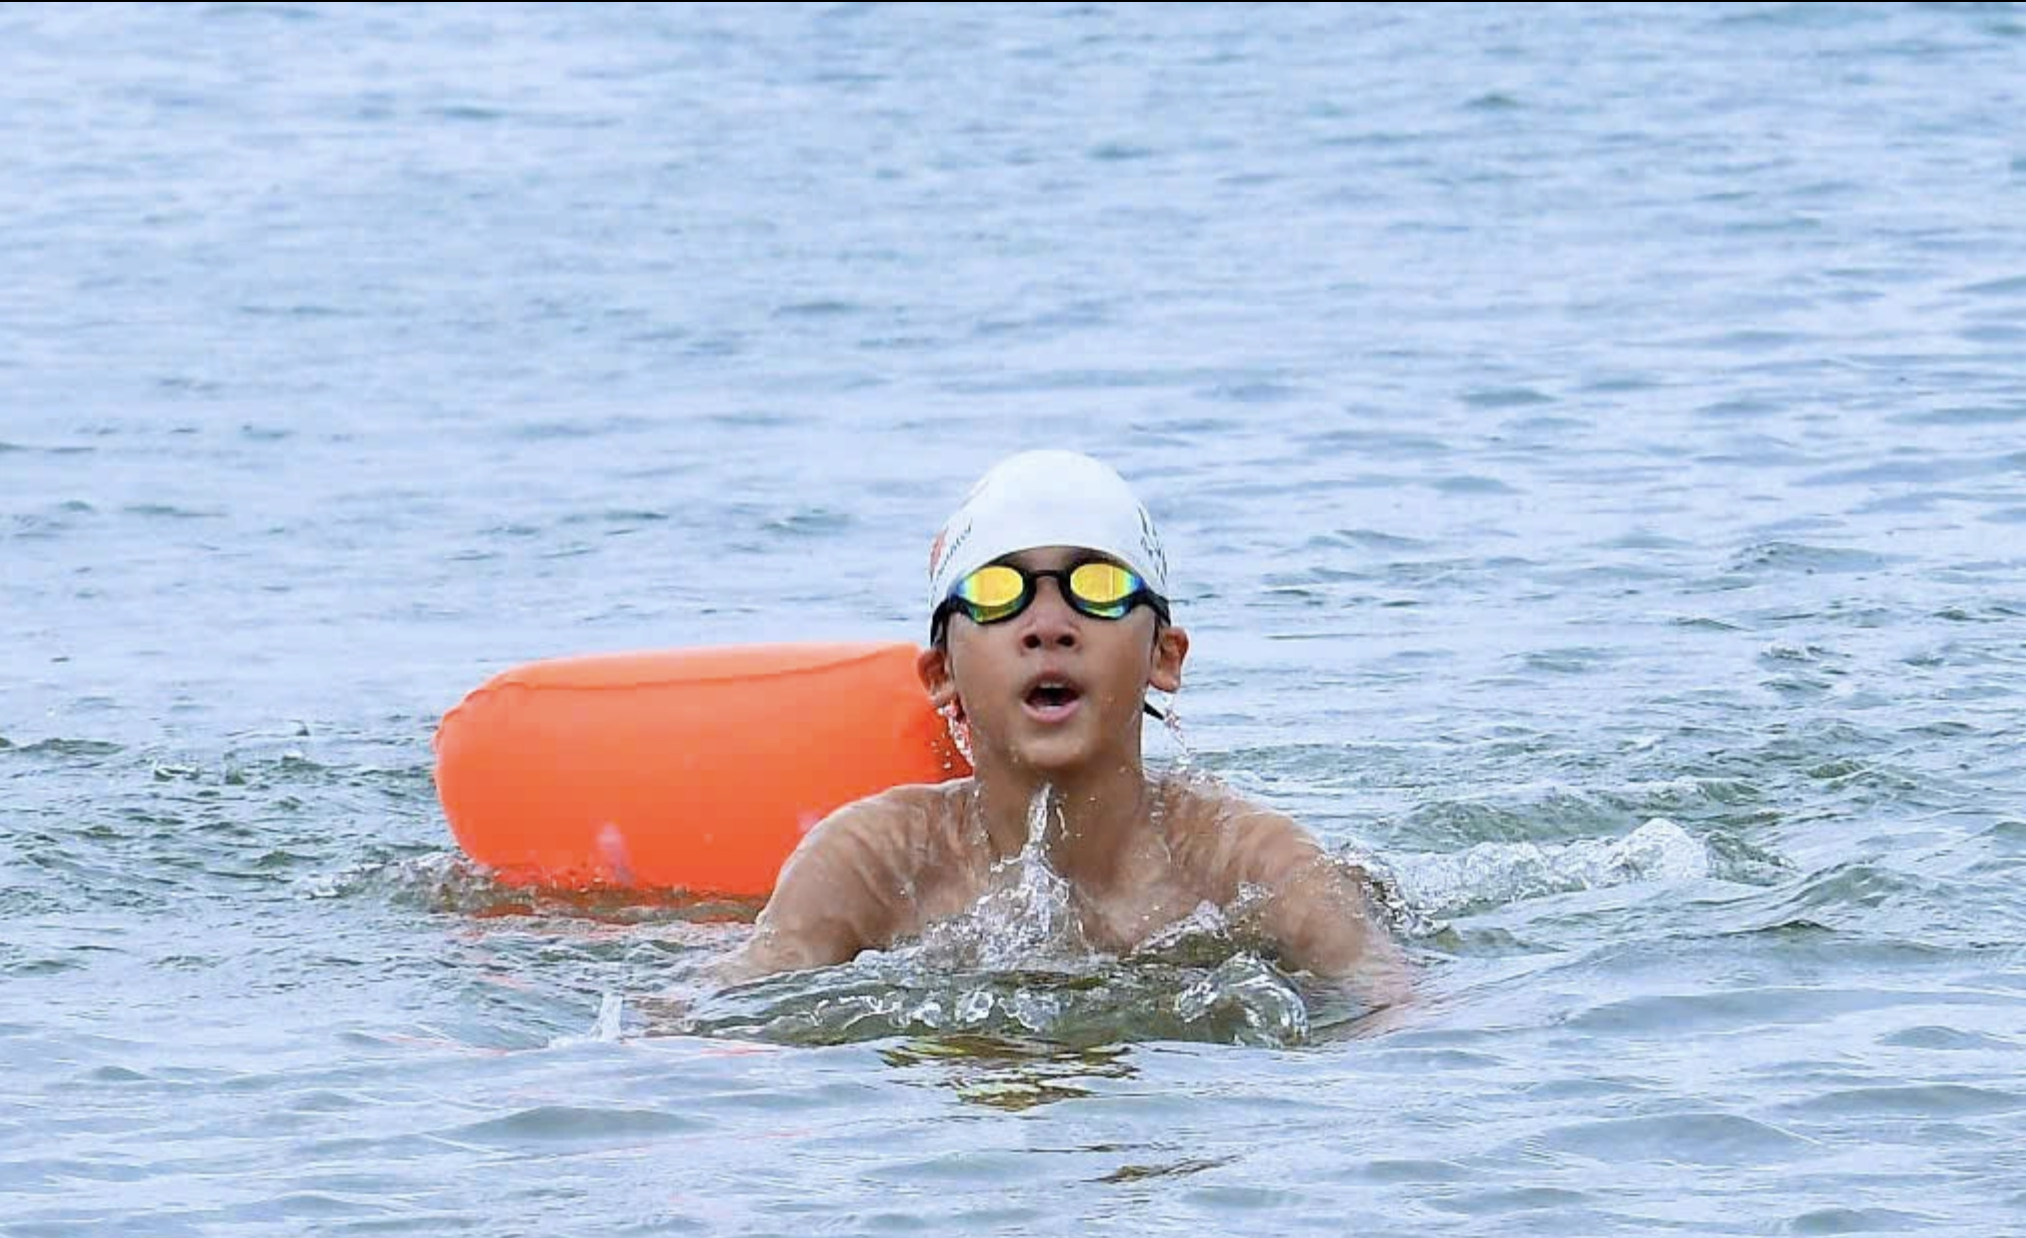

In [8]:
# Load the original image using the image service
img = writing_tool.image_service.load_image(image_url)

# Display image information
info = writing_tool.image_service.get_image_info(img)
logger.info(f"Image info: {info}")

# Display the image
img

In [9]:
# Create transparency overlay using the image service
if combined_mask.size > 0:
    img_with_mask = writing_tool.image_service.create_transparency_overlay(
        img, combined_mask
    )
    logger.info(f"Transparency overlay created!")
    logger.info(f"   - Image mode: {img_with_mask.mode}")
    logger.info(f"   - Image size: {img_with_mask.size}")
else:
    img_with_mask = img.convert("RGBA")
    logger.info("No mask available, using original image")

2025-08-02 16:17:01,723 - __main__ - INFO - Transparency overlay created!
2025-08-02 16:17:01,723 - __main__ - INFO -    - Image mode: RGBA
2025-08-02 16:17:01,724 - __main__ - INFO -    - Image size: (2026, 1238)
2025-08-02 16:17:01,723 - __main__ - INFO -    - Image mode: RGBA
2025-08-02 16:17:01,724 - __main__ - INFO -    - Image size: (2026, 1238)


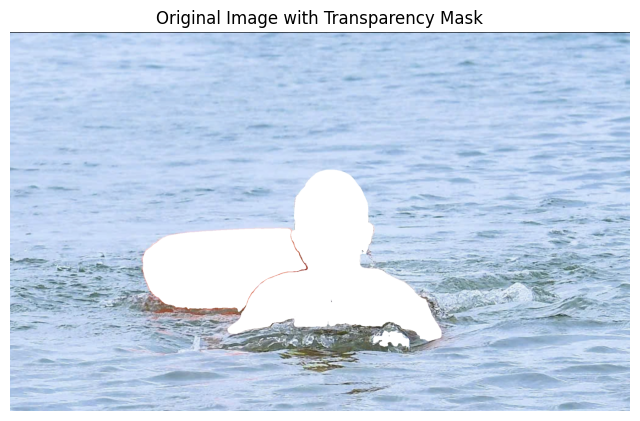

In [10]:
# Display the image with transparency overlay
plt.figure(figsize=(8, 6))
plt.imshow(img_with_mask)
plt.title("Original Image with Transparency Mask")
plt.axis("off")
plt.show()

## Editing Prompt Examples

Various text descriptions that can be used to guide the image editing process.

In [11]:
prompt = """
A young boy is swimming in open water, wearing a white swim cap and reflective goggles. He appears focused and determined as he moves through the water, creating small splashes around him. An orange buoy is attached to him for safety, floating just behind his back.
"""

## AI-Powered Image Editing

Use Hugging Face's diffusers library with DreamShaper-8 inpainting model to modify the masked areas of the image. This approach runs locally on your GPU and doesn't require API keys.

In [12]:
# Demonstrate the new Hugging Face-based inpainting service
# Let's use our detected cats image and the mask we created

if combined_mask.size > 0:
    # Create a proper mask for diffusers (RGB with 255 for areas to inpaint)
    diffusers_mask = writing_tool.inpainting_service.create_mask_for_diffusers(
        combined_mask, image_array.shape
    )

    # diffusers_mask = writing_tool.inpainting_service.create_mask_from_boxes(
    #     [detection.box for detection in detections], image_array.shape
    # )

    # Convert the diffusers mask to PIL Image
    mask_image = Image.fromarray(diffusers_mask)

    logger.info(f"Using prompt: {prompt}")
    logger.info(f"Original image size: {img.size}")
    logger.info(f"Mask shape: {diffusers_mask.shape}")

    # Perform inpainting using our service
    edited_image = writing_tool.inpainting_service.inpaint(
        image=img,
        mask=mask_image,
        prompt=prompt,
        size=(512, 512),  # Resize to 512x512 for faster processing
        num_inference_steps=25,
        generator_seed=33,  # For reproducible results
    )

    logger.info("Inpainting completed!")
else:
    logger.info("No mask available for inpainting")

2025-08-02 16:17:01,952 - __main__ - INFO - Using prompt: 
A young boy is swimming in open water, wearing a white swim cap and reflective goggles. He appears focused and determined as he moves through the water, creating small splashes around him. An orange buoy is attached to him for safety, floating just behind his back.

2025-08-02 16:17:01,952 - __main__ - INFO - Original image size: (2026, 1238)
2025-08-02 16:17:01,952 - __main__ - INFO - Mask shape: (1238, 2026, 3)
2025-08-02 16:17:01,952 - __main__ - INFO - Original image size: (2026, 1238)
2025-08-02 16:17:01,952 - __main__ - INFO - Mask shape: (1238, 2026, 3)


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]



2025-08-02 16:17:22,422 - __main__ - INFO - Inpainting completed!


In [13]:
diffusers_mask.shape

(1238, 2026, 3)

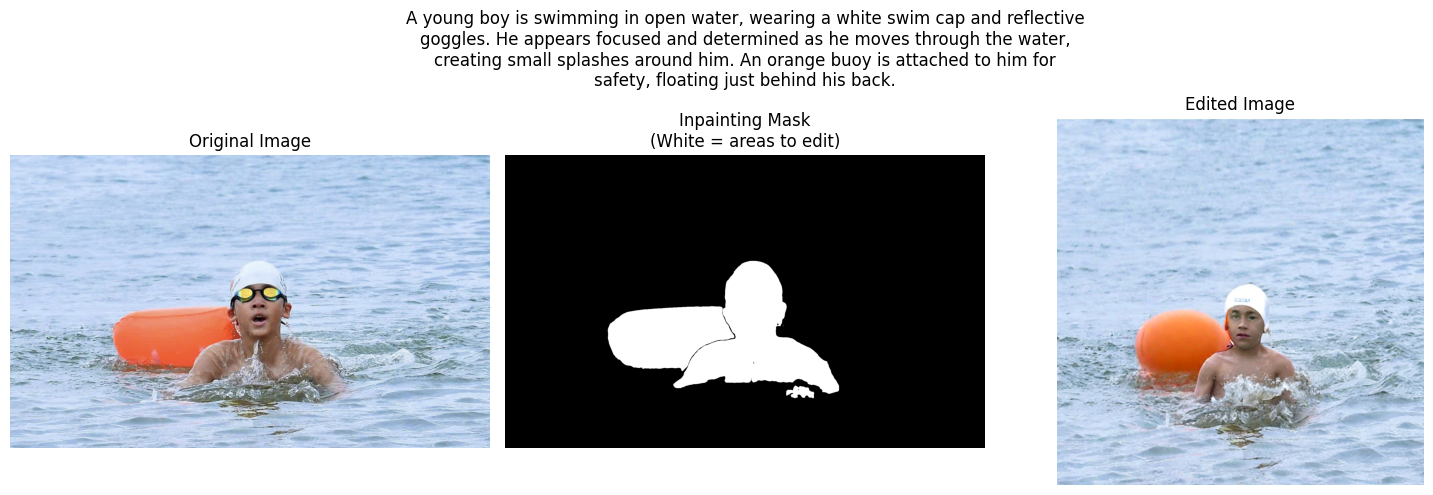

2025-08-02 16:23:30,948 - __main__ - INFO - Comparison complete!


In [26]:
# Display original and edited images side by side
if combined_mask.size > 0 and "edited_image" in locals():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Mask visualization
    axes[1].imshow(diffusers_mask)
    axes[1].set_title("Inpainting Mask\n(White = areas to edit)")
    axes[1].axis("off")

    # Edited image
    axes[2].imshow(edited_image)
    axes[2].set_title("Edited Image")
    axes[2].axis("off")

    # Show prompt in the title, cut text into smaller parts if too long, each line containing up to 50 characters
    prompt_lines = []
    words = prompt.split()
    line = ""
    for word in words:
        if len(line) + len(word) + 1 <= 80:  # +1 for the space
            line += word + " "
        else:
            prompt_lines.append(line.strip())
            line = word + " "
    if line:  # Add the last line if it exists
        prompt_lines.append(line.strip())
    plt.suptitle("\n".join(prompt_lines), fontsize=12)
    # Adjust layout
    plt.subplots_adjust(top=0.85)  # Adjust top margin for title

    plt.tight_layout()
    plt.show()

    logger.info("Comparison complete!")
else:
    logger.info("No images to compare")